<참조 : https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko>

## 사전학습된 ConvNet을 이용한 전이 학습
- pretrained / transfer : 사전훈련 / 전이학습
  - 고양이와 개의 이미지 분류  
    
- 사전 훈련된 모델을 사용자 정의하는 방법
  - 특징 추출 : 사전 훈련된 모델 위에 처음부터 교육할 새 분류기를 추가
    - 이전 데이터셋으로 학습한 특징 맵의 용도를 재사용할 수 있습니다
    - 전체 모델을 재훈련시키지 않아도 됩니다  
      
  - 미세 조정(Fine Tuning)
    - 고정된 기본 모델의 일부 최상위 층을 고정 해제
    - 새로 추가된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시킵니다
      - 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 관련성이 있도록 할 수 있습니다.

#### machine learning 과정
- 데이터 검사 및 이해
- 입력 파이프 라인 빌드 : Keras ImageDataGenerator 사용
- 모델 작성
  - 사전 훈련된 기본 모델(또한 사전 훈련된 가중치)에 적재
  - 분류 층을 맨 위에 쌓기
- 모델 훈련
- 모델 평가

### 01. 데이터 전처리

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

In [41]:
try:
    # %tensorflow_verwion은 Colab에서만 지원됩니다
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

keras = tf.keras

#### 01. 01. 데이터 다운로드

In [42]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

- "cats_vs_dogs" : 표준 splits 기능을 제공하지 않음
  - subsplit 기능을 사용

In [43]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [44]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


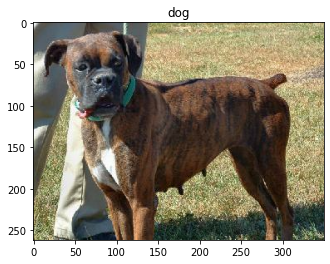

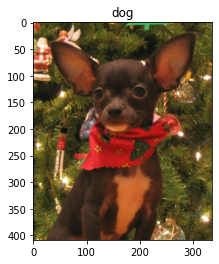

In [45]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

#### 01. 02. 데이터 포맷

In [46]:
IMG_SIZE = 160    # 모든 이미지는 160x160으로 크기가 조정됩니다

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1    # 입력 채널의 크기를 [-1, 1] 범위
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [47]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [48]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [49]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [50]:
# 일련의 데이터 검사하기
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

### 02. 사전 훈련된 컨볼루션 네트워크로 기본 모델 생성하기
- pretrained model : MobileNet V2
  - ImageNet으로 훈련된 가중치가 저장 : 인스턴스화 - 할당해주는 것과 비슷
  - 가장 최근의 분류 층 : "맨 위층", 머신러닝 모델 다이어그램은 아래에서 위로 이동
    - 유용하지 않습니다
    - **include_top=False** 지정 : 맨 위의 분류 층이 포함되지 않습니다
  - flatten 연산을 하기 전에 맨 아래 층으로 진행
    - "병목 층" : 맨 위층보다 일반성을 유지

In [51]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# pretrained model : MobileNet V2 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [52]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 03. 특징 추출

#### 03. 01. 컨볼루션 베이스 모델 고정하기
- 고정 : **layer.trainable=False**
  - 훈련 중 지정된 층의 가중치가 업데이트되지 않습니다.

In [53]:
base_model.trainable = False

In [54]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#### 03. 02. 분류 층을 맨 위에 추가하기

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [56]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [57]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

#### 03. 03. 모델 컴파일

In [58]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


#### 03. 04. 모델 훈련

In [60]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 2s 62ms/step - loss: 0.9063 - accuracy: 0.3922


In [61]:
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

initial loss: 0.91
initial accuracy: 0.39


In [62]:
history = model.fit(train_batches,
                   epochs=initial_epochs,
                   validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 52s 83ms/step - loss: 0.2429 - accuracy: 0.8891 - val_loss: 0.0874 - val_accuracy: 0.9682
Epoch 2/10
582/582 [==============================] - 60s 101ms/step - loss: 0.0754 - accuracy: 0.9726 - val_loss: 0.0620 - val_accuracy: 0.9768
Epoch 3/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0602 - accuracy: 0.9774 - val_loss: 0.0538 - val_accuracy: 0.9798
Epoch 4/10
582/582 [==============================] - 50s 83ms/step - loss: 0.0538 - accuracy: 0.9795 - val_loss: 0.0499 - val_accuracy: 0.9819
Epoch 5/10
582/582 [==============================] - 49s 81ms/step - loss: 0.0501 - accuracy: 0.9807 - val_loss: 0.0476 - val_accuracy: 0.9828
Epoch 6/10
582/582 [==============================] - 48s 80ms/step - loss: 0.0477 - accuracy: 0.9815 - val_loss: 0.0461 - val_accuracy: 0.9832
Epoch 7/10
582/582 [==============================] - 49s 82ms/step - loss: 0.0459 - accuracy: 0.9822 - val_loss: 0.0452 - val_accuracy

#### 03. 05. 학습 곡선 

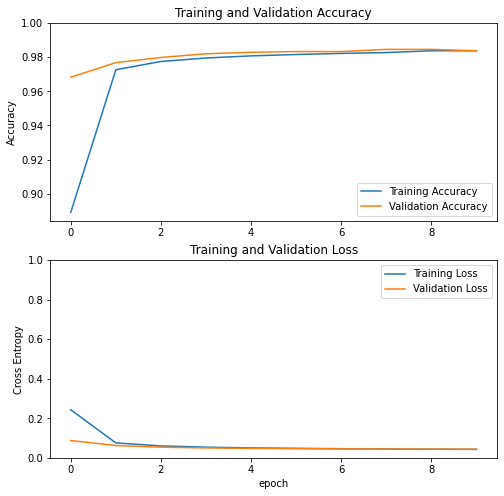

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 04. 미세 조정 : Fine Tuning
- 사전 훈련된 네트워크의 가중치는 훈련 중 업데이트되지 않았습니다
- 성능 향상을 위한 방법
  - 추가한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련하는 것
    - Fine Tuning
    - 사전 훈련된 모델을 훈련 불가능으로 설정하여 훈련한 후에만 시도

#### 04. 01. 최상위층 고정 해제하기

In [64]:
base_model.trainable = True

In [65]:
print('Number of layers in the base model: ', len(base_model.layers))

# 해당 층 이후부터 미세 조정
fine_tune_at = 100

# 'fine_tune_at' 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


#### 04. 02. 모델 컴파일

In [66]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


#### 04. 03. 모델 훈련 계속하기

In [68]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 56s 87ms/step - loss: 0.1287 - accuracy: 0.9518 - val_loss: 0.0780 - val_accuracy: 0.9789
Epoch 11/20
582/582 [==============================] - 52s 87ms/step - loss: 0.0673 - accuracy: 0.9730 - val_loss: 0.0557 - val_accuracy: 0.9815
Epoch 12/20
582/582 [==============================] - 51s 85ms/step - loss: 0.0500 - accuracy: 0.9801 - val_loss: 0.0497 - val_accuracy: 0.9824
Epoch 13/20
582/582 [==============================] - 52s 86ms/step - loss: 0.0402 - accuracy: 0.9845 - val_loss: 0.0504 - val_accuracy: 0.9807
Epoch 14/20
582/582 [==============================] - 52s 86ms/step - loss: 0.0308 - accuracy: 0.9886 - val_loss: 0.0514 - val_accuracy: 0.9815
Epoch 15/20
582/582 [==============================] - 51s 86ms/step - loss: 0.0254 - accuracy: 0.9904 - val_loss: 0.0538 - val_accuracy: 0.9807
Epoch 16/20
582/582 [==============================] - 51s 85ms/step - loss: 0.0201 - accuracy: 0.9932 - val_loss: 0.0534 - val_ac

In [69]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

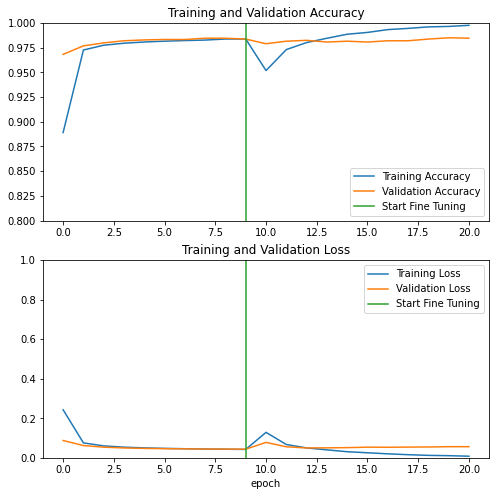

In [70]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()